# Winter Arctic sea ice state variability (updates through to April 2023)

**Summary**: In this notebook, we provide the second update to the original winter Arctic sea ice thickness notebooks with an additional winter (2022-2023) of data collection using rel006 data. At the end of the notebook we include a few additional plots to try and better highlight the variable sea ice thickness data.

**Version history**: Version 1 (08/21/2023)
 

# Import notebook dependencies

In [1]:
# For working with gridded climate data 
import xarray as xr 
# Helper function for reading the data from the bucket
from utils.read_data_utils import read_IS2SITMOGR4, read_ISSITGR4
from utils.plotting_utils import static_winter_comparison_lineplot, staticArcticMaps, staticArcticMaps_overlayDrifts, interactiveArcticMaps, compute_gridcell_winter_means, interactive_winter_comparison_lineplot # Plotting utils 
import numpy as np
import holoviews as hv
import pandas as pd
import pyproj
import scipy.interpolate 
# Plotting dependencies
#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
# Sets figure size in the notebook
mpl.rcParams['figure.dpi'] = 150 

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

In [2]:
# Read in the raw monthly gridded winter Arctic sea ice data from local storage (includes prelim data in this case)
IS2SITMOGR4_all = read_IS2SITMOGR4(data_type='netcdf', local_data_path='/data/IS2SITMOGR4/', version='') 
IS2SITMOGR4_all

/Users/akpetty/GitHub/icesat2-book/content
local netcdf files available, use these
Load in netcdf files to xarray dataset
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_201910_005_002.nc
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_202111_005_002.nc
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_202302_006_002.nc
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_201901_005_002.nc
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_202011_005_002.nc
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_201904_005_002.nc
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_202203_005_002.nc
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_201909_005_002.nc
/Users/akpetty/GitHub/icesat2-book/content/data/IS2SITMOGR4/IS2SITMOGR4_01_201912_005_002.nc
/Users/akpetty/GitHub/icesat2-book/conten

<xarray.Dataset>
Dimensions:            (time: 38, y: 448, x: 304)
Coordinates:
  * time               (time) datetime64[ns] 2018-11-01 ... 2023-04-01
    longitude          (y, x) float32 168.3 168.1 168.0 ... -10.36 -10.18 -9.999
    latitude           (y, x) float32 31.1 31.2 31.3 31.39 ... 34.68 34.58 34.47
    xgrid              (y, x) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
    ygrid              (y, x) float32 5.838e+06 5.838e+06 ... -5.338e+06
Dimensions without coordinates: y, x
Data variables: (12/15)
    projection         (time) float64 -2.147e+09 -2.147e+09 ... -2.147e+09
    ice_thickness      (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    ice_thickness_unc  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    num_segments       (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    mean_day_of_month  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    snow_depth         (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                 ...
    ice_density        (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    ice_thickness_int  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    freeboard_int      (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    snow_depth_int     (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    sea_ice_conc       (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    region_mask        (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    contact:      Alek Petty (alek.a.petty@nasa.gov)
    description:  Gridded Oct 2019 Arctic sea ice thickness and ancillary dat...
    reference:    Data doi: 10.5067/CV6JEXEE31HF. Data described in Petty, A....
    history:      Created 28/04/22

In [3]:
# Years over which to perform analysis
years = [2018,2019,2020, 2021, 2022]

# Winter mean Arctic maps (static)
Compute and map (static) mean winter sea ice conditions across the years of analysis chosen

In [4]:
#freeboard_winter_means.time.values

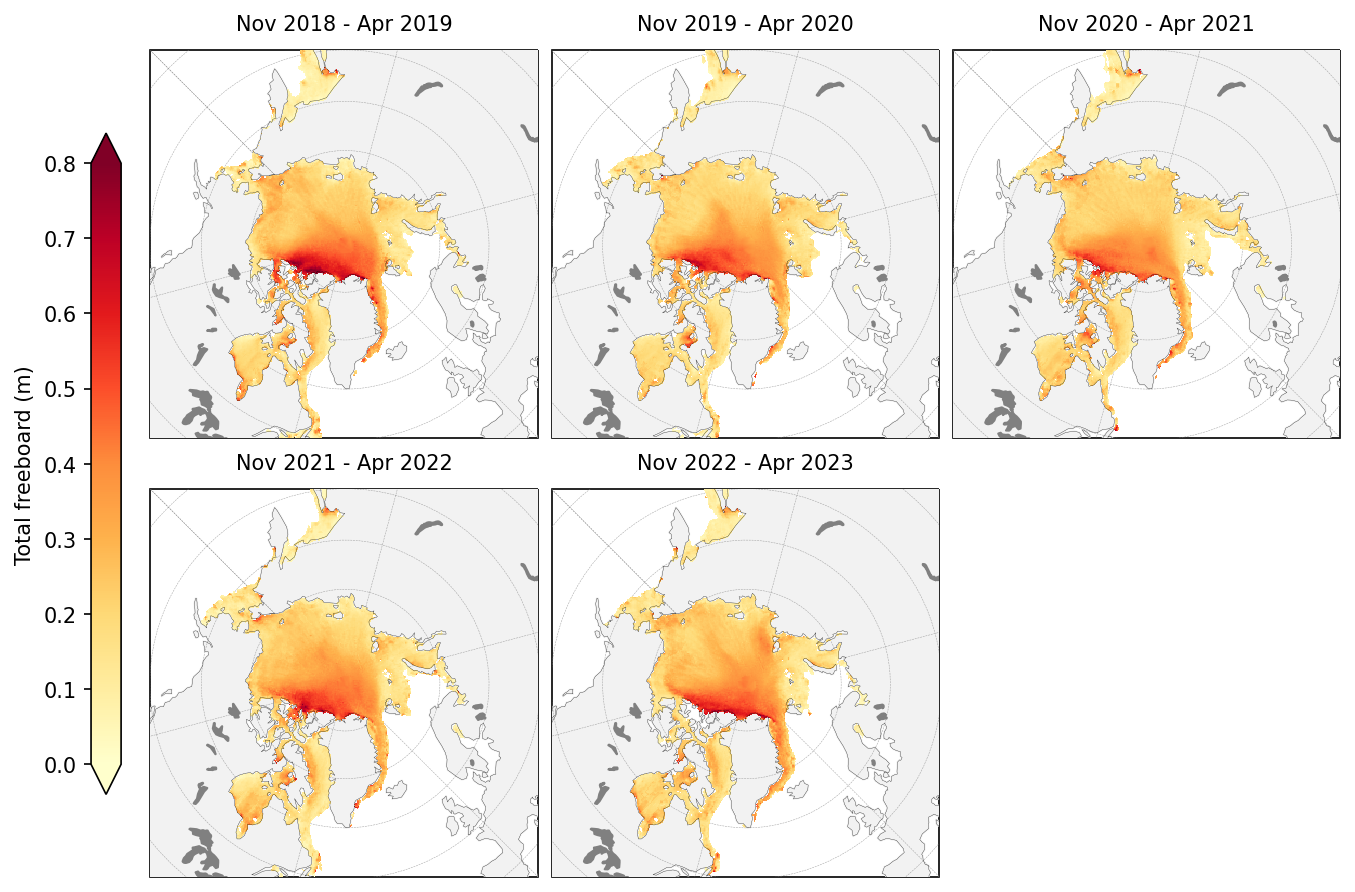

In [5]:
freeboard_winter_means = compute_gridcell_winter_means(IS2SITMOGR4_all.freeboard_int, years=years)
staticArcticMaps(freeboard_winter_means, dates=freeboard_winter_means.time.values, set_cbarlabel = "Total freeboard (m)", cmap="YlOrRd", col_wrap=3, vmin=0, vmax=0.8, out_str='freeboard_winter_2018_2023')


# Monthly mean timeseries (overlaid)
Next we'll compute monthly means by averaging over all gridcells within a given region. We'll use this to generate a lineplot to compare across the three winter seasons for each variable.

In [6]:
# Here is where we might also want to set a region mask, e.g. to avoid including some of the more uncertain data in the peripheral seas
innerArctic = [1,2,3,4,5,6]
IS2SITMOGR4_all_innerArctic = IS2SITMOGR4_all.where(IS2SITMOGR4_all.region_mask.isin(innerArctic))

# Uncomment out to set an additional ice type mask too and change the save_label accordingly (0 = FYI, 1 = MYI)
#IS2SITMOGR4_all_innerArctic = IS2SITMOGR4_all_innerArctic.where(IS2SITMOGR4_all_innerArctic.ice_type==1)

save_label='Inner_Arctic'


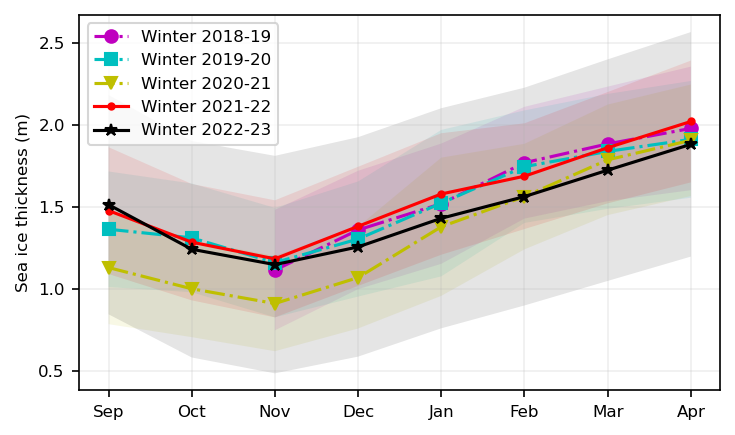

In [7]:
static_winter_comparison_lineplot(IS2SITMOGR4_all_innerArctic.ice_thickness, 
                                  da_unc = IS2SITMOGR4_all_innerArctic.ice_thickness_unc, 
                                  years=years, start_month="Sep", figsize=(5,3), 
                                  fmts = ['mo-.','cs-.','yv-.','r.-','k*-'],
                                  set_ylabel='Sea ice thickness (m)', save_label=save_label, annotation='', legend=True)

# Monthly mean timeseries (adjacent years)
Plot the data in time to show seasonal changes. 

Utilize holoviews and the BGEP/CS-2/PIOMAS plotting functions from previous notebooks

In [8]:
# Drop Sep and October as coverage issues means they are hard to interpret
IS2SITMOGR4_all_innerArctic_Nov = IS2SITMOGR4_all_innerArctic.where(((IS2SITMOGR4_all_innerArctic['time.month'] > 10)|(IS2SITMOGR4_all_innerArctic['time.month'] < 5)), drop=True)

# Take monthly means
IS2SITMOGR4_all_innerArctic_mean = IS2SITMOGR4_all_innerArctic_Nov.mean(dim=("x","y"), skipna=True, keep_attrs=True)

# Holoviews requires us to generate individual line plots then combine later
is2_lineplot_p = IS2SITMOGR4_all_innerArctic_mean.ice_thickness_int.hvplot.line(grid=True, color='k', frame_width=700, frame_height=250) * IS2SITMOGR4_all_innerArctic_mean.ice_thickness_int.hvplot.scatter(marker='x', color='k', size=40) # Overlay scatter plot to add markers

is2_lineplot_p.opts(title=" IS2SITMOGR4 V2/V3 2018-2023 (Nov 2022 to Apr 2023 based on rel006)", fontsize=10)
is2_lineplot_p.opts(ylabel="Mean sea ice thickness (meters)")
display(is2_lineplot_p)
hv.save(is2_lineplot_p, './figs/icesat-2_thickness_int_2018-2023.png', fmt='png', dpi=300)

:Overlay
   .Curve.I   :Curve   [time]   (ice_thickness_int)
   .Scatter.I :Scatter   [time]   (ice_thickness_int)

In [9]:
# Total freeboard (ATL10)
is2_lineplot_p = IS2SITMOGR4_all_innerArctic_mean.freeboard_int.hvplot.line(grid=True, color='b', frame_width=700, frame_height=250) * IS2SITMOGR4_all_innerArctic_mean.freeboard_int.hvplot.scatter(marker='x', color='b', size=40) # Overlay scatter plot to add markers

is2_lineplot_p.opts(title=" IS2SITMOGR4 V2/V3 2018-2023 (Nov 2022 to Apr 2023 based on rel006)", fontsize=10)
is2_lineplot_p.opts(ylabel="Mean total freeboard (meters)")
display(is2_lineplot_p)
hv.save(is2_lineplot_p, './figs/icesat-2_freeboard_2018-2023.png', fmt='png', dpi=300)

:Overlay
   .Curve.I   :Curve   [time]   (freeboard_int)
   .Scatter.I :Scatter   [time]   (freeboard_int)

# 2018-2023 ICESat-2 winter Arctic thickness 'climatology'
NB: Aware that realistically 5 years isn't long enough to be considered a climatology, really just a modern-era mean



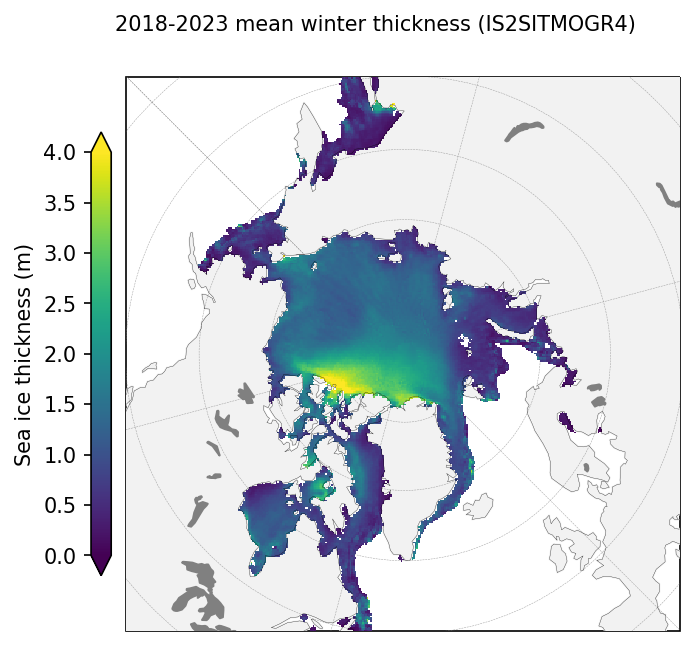

In [10]:
thickness_winter_means = compute_gridcell_winter_means(IS2SITMOGR4_all.ice_thickness_int, years=years)
staticArcticMaps(thickness_winter_means.mean(axis=0), title='2018-2023 mean winter thickness (IS2SITMOGR4)',col=0, col_wrap=1, set_cbarlabel = "Sea ice thickness (m)", cmap="viridis", vmin=0, vmax=4, out_str='thickness_winter_mean_2018_2023')


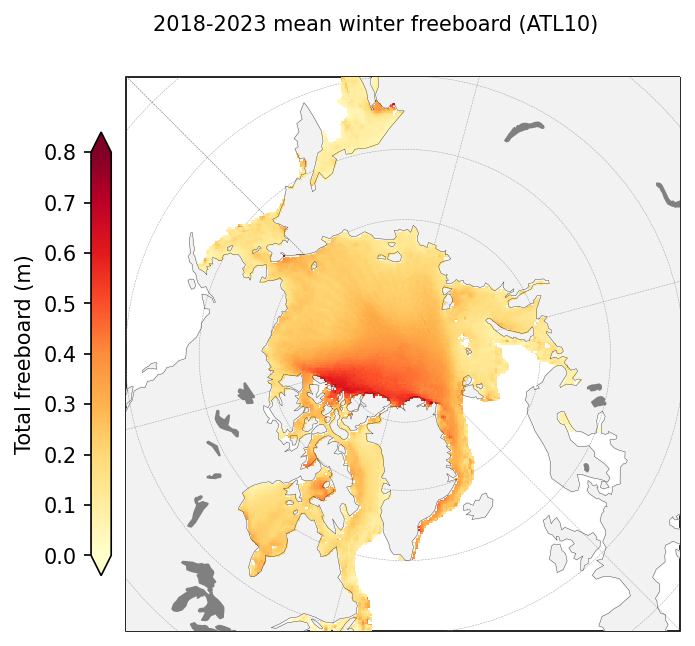

In [11]:
freeboard_winter_means = compute_gridcell_winter_means(IS2SITMOGR4_all.freeboard_int, years=years)
staticArcticMaps(freeboard_winter_means.mean(axis=0), title='2018-2023 mean winter freeboard (ATL10)',col=0, col_wrap=1, set_cbarlabel = "Total freeboard (m)", cmap="YlOrRd", vmin=0, vmax=0.8, out_str='freeboard_winter_mean_2018_2023')


# ICESat data
OK let's try and read in the recently released ICESat (2003-2008) data and see how that compares to the more recent ICESat-2 data


In [12]:

# Read in the raw monthly gridded winter Arctic sea ice data from S3
ISSITGR4_all = read_ISSITGR4(local_data_path='/data/ISSITGR4/', version='001') 


/Users/akpetty/GitHub/icesat2-book/content
Load in netcdf files to xarray dataset
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_ON04_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_FM04_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_FM08_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_FM06_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_ON06_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_ON03_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_FM03_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_MA07_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_FM05_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR4_01_ON05_001.nc
/Users/akpetty/GitHub/icesat2-book/content/data/ISSITGR4/001/ISSITGR

In [13]:
# APPLY REGION MASK TO ICESAT DATA
ISSITGR4_all_innerArctic = ISSITGR4_all.where(ISSITGR4_all.region_mask.isin(innerArctic))

# Uncomment out to set an additional ice type mask too and change the save_label accordingly (0 = FYI, 1 = MYI)
#IS2SITMOGR4_all_innerArctic = IS2SITMOGR4_all_innerArctic.where(IS2SITMOGR4_all_innerArctic.ice_type==1)

In [14]:
ISSITGR4_all

<xarray.Dataset>
Dimensions:                      (x: 304, y: 448, time: 11)
Coordinates:
  * x                            (x) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                            (y) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * time                         (time) datetime64[ns] 2003-03-10T12:00:00 .....
    longitude                    (y, x) float32 168.3 168.1 ... -10.18 -9.999
    latitude                     (y, x) float32 31.1 31.2 31.3 ... 34.58 34.47
Data variables: (12/16)
    crs                          (time) float64 -2.147e+09 ... -2.147e+09
    campaign_dates               (time) float64 -2.147e+09 ... -2.147e+09
    ice_thickness                (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc            (time, y, x) float32 nan nan nan ... nan nan
    num_shots                    (time, y, x) float64 nan nan nan ... nan nan
    mean_day_of_campaign_period  (time, y, x) float32 nan nan nan ... nan nan
    ...                           ...
    ice_density                  (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_int            (time, y, x) float32 nan nan nan ... nan nan
    total_freeboard_int          (time, y, x) float32 nan nan nan ... nan nan
    snow_depth_int               (time, y, x) float32 nan nan nan ... nan nan
    sea_ice_conc                 (time, y, x) float32 nan nan nan ... nan nan
    region_mask                  (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    contact:      Alek Petty (alek.a.petty@nasa.gov)
    description:  Gridded ON04 Arctic sea ice thickness and ancillary data, c...
    reference:    Original methodology described in Petty, A. A., N. T. Kurtz...
    history:      Created 13/04/23

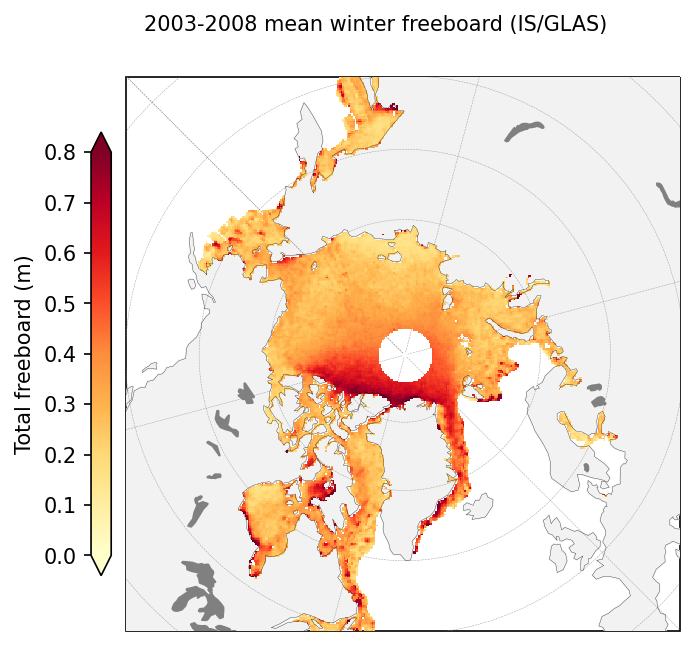

In [15]:
staticArcticMaps(ISSITGR4_all.total_freeboard_int.mean('time'), title='2003-2008 mean winter freeboard (IS/GLAS)',col=0, col_wrap=1, set_cbarlabel = "Total freeboard (m)", cmap="YlOrRd", vmin=0, vmax=0.8, out_str='freeboard_winter_mean_2003_2008')

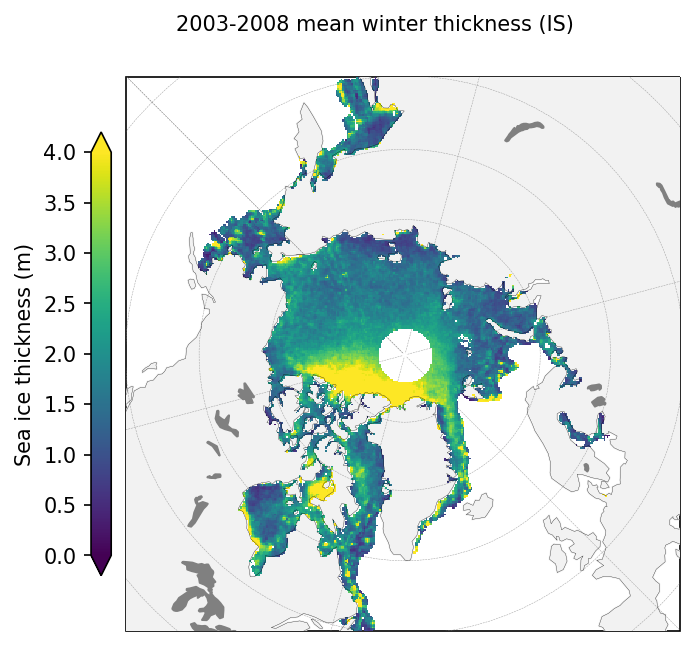

In [16]:
staticArcticMaps(ISSITGR4_all.ice_thickness_int.mean('time'), title='2003-2008 mean winter thickness (IS)',col=0, col_wrap=1, set_cbarlabel = "Sea ice thickness (m)", cmap="viridis", vmin=0, vmax=4, out_str='ice_thickbess_winter_mean_2003_2008')


In [17]:
# LET'S ADD LANDY DATA TO THIS??? THEN PIOMAS IN BACKGROUND??


# Drop just Sep here as coverage issues means they are hard to interpret but IS includes October so let's keep that
IS2SITMOGR4_all_innerArctic_Oct_Apr = IS2SITMOGR4_all_innerArctic.where(((IS2SITMOGR4_all_innerArctic['time.month'] > 9)|(IS2SITMOGR4_all_innerArctic['time.month'] < 5)), drop=True)
# Take monthly means
IS2SITMOGR4_all_innerArctic_mean = IS2SITMOGR4_all_innerArctic_Oct_Apr.mean(dim=("x","y"), skipna=True, keep_attrs=True)

# Take monthly means
ISSITGR4_all_innerArctic_mean = ISSITGR4_all_innerArctic.mean(dim=("x","y"), skipna=True, keep_attrs=True)



# Holoviews requires us to generate individual line plots then combine later
is2_lineplot_p = IS2SITMOGR4_all_innerArctic_mean.ice_thickness_int.hvplot.line(grid=True, color='k', frame_width=700, frame_height=250, label="IS2SITMOGR4") * IS2SITMOGR4_all_innerArctic_mean.ice_thickness_int.hvplot.scatter(marker='x', color='k', size=40) # Overlay scatter plot to add markers

# Holoviews requires us to generate individual line plots then combine later
is_lineplot_p = ISSITGR4_all_innerArctic_mean.ice_thickness_int.hvplot.line(grid=True, color='b', frame_width=700, frame_height=250, label="ISSITGR4") * ISSITGR4_all_innerArctic_mean.ice_thickness_int.hvplot.scatter(marker='x', color='b', size=40) # Overlay scatter plot to add markers

plots = is_lineplot_p*is2_lineplot_p
plots.opts(ylabel="Mean Inner Arctic sea ice thickness (m)")
plots.opts(title=" IS2SITGR4 (2003-2008), IS2SITMOGR4 (2018-2023, Nov 2022 to Apr 2023 based on rel006)")
plots.opts(legend_position='top_right')
display(plots)
hv.save(plots, './figs/icesat_icesat-2_thickness_int_2003-2023.png', fmt='png', dpi=300)

:Overlay
   .Curve.ISSITGR4    :Curve   [time]   (ice_thickness_int)
   .Scatter.I         :Scatter   [time]   (ice_thickness_int)
   .Curve.IS2SITMOGR4 :Curve   [time]   (ice_thickness_int)
   .Scatter.II        :Scatter   [time]   (ice_thickness_int)

In [18]:
def getCS2ubris(dataPathCS2):
    """ Read in the University of Bristol CryoSat-2 sea ice thickness data

    
    Args:
        dataPathCS2 (str): location of data
        
    Returns
        xptsT (2d numpy array): x coordinates on our map projection
        yptsT (2d numpy array): y coordinates on our map projection
        thicknessCS (2d numpy array): monthly sea ice thickness estimates
        

    """
    ubris_f = xr.open_dataset(dataPathCS2+'/UBRIS/ubristol_cryosat2_seaicethickness_nh_80km_v1p7.nc', decode_times=False)

    # Issue with time starting from year 0!
    # Re-set it to start from some other year
    ubris_f = ubris_f.rename({'Time':'time'})
    ubris_f['time'] = ubris_f['time']-679352
    ubris_f.time.attrs["units"] = "days since 1860-01-01"
    decoded_time = xr.decode_cf(ubris_f)

    ubris_f['time']=decoded_time.time
    ubris_f = ubris_f.swap_dims({'t': 'time'})

    # Resample to monthly, note that the S just makes the index start on the 1st of the month
    thicknessCS = ubris_f.resample(time="MS").mean()
    xptsT, yptsT = mapProj(thicknessCS.isel(time=0).Longitude, thicknessCS.isel(time=0).Latitude)
    
    return xptsT, yptsT, thicknessCS

def regridToICESat2(dataArrayNEW, xptsNEW, yptsNEW, xptsIS2, yptsIS2):  
    """ Regrid new data to ICESat-2 grid 
    
    Args: 
        dataArrayNEW (xarray DataArray): Numpy variable array to be gridded to ICESat-2 grid 
        xptsNEW (numpy array): x-values of dataArrayNEW projected to ICESat-2 map projection 
        yptsNEW (numpy array): y-values of dataArrayNEW projected to ICESat-2 map projection 
        xptsIS2 (numpy array): ICESat-2 longitude projected to ICESat-2 map projection
        yptsIS2 (numpy array): ICESat-2 latitude projected to ICESat-2 map projection
    
    Returns: 
        gridded (numpy array): data regridded to ICESat-2 map projection
    
    """
    #gridded = []
    #for i in range(len(dataArrayNEW.values)): 
    gridded = scipy.interpolate.griddata((xptsNEW.flatten(),yptsNEW.flatten()), dataArrayNEW.flatten(), (xptsIS2, yptsIS2), method = 'nearest')
    try:
        gridded = scipy.interpolate.griddata((xptsNEW.flatten(),yptsNEW.flatten()), dataArrayNEW.flatten(), (xptsIS2, yptsIS2), method = 'nearest')
    except:
        try:
            gridded = scipy.interpolate.griddata((xptsNEW,yptsNEW), dataArrayNEW, (xptsIS2, yptsIS2), method = 'nearest')
        except:
            print('Error interpolating..')
    
    return gridded

# Initialize map projection and project data to it
out_proj = 'EPSG:3411'
mapProj = pyproj.Proj("+init=" + out_proj)

xptsIS2 = IS2SITMOGR4_all_innerArctic.xgrid.values
yptsIS2 = IS2SITMOGR4_all_innerArctic.ygrid.values

out_lons = IS2SITMOGR4_all_innerArctic.longitude.values
out_lats = IS2SITMOGR4_all_innerArctic.latitude.values

start_date = "Oct 2010"
end_date = "Apr 2020"
date_range = pd.date_range(start=start_date, end=end_date, freq='MS') # MS indicates a time frequency of start of the month
#date_range = date_range[((date_range.month <5) | (date_range.month > 8))]
date_range

dataPathCS2='/Users/akpetty/Data/CS2'
cs2_ubris = []
valid_dates=[]

xptsT_ubris, yptsT_ubris, cs2_ubris_raw = getCS2ubris(dataPathCS2)


In [19]:
for date in date_range:
     
    try:
        cs2_ubris_temp_is2grid = regridToICESat2(cs2_ubris_raw.Sea_Ice_Thickness.sel(time=date).values, xptsT_ubris, yptsT_ubris, xptsIS2, yptsIS2) 
         
    except:
        print(date)
        print('no CS-2 data so skipping...')
        continue
    valid_dates.append(date)
    
    
    cs2_ubris_temp_is2grid_xr = xr.DataArray(data = cs2_ubris_temp_is2grid, 
                            dims = ['y', 'x'], 
                            coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), 'region_mask': (('y','x'), ISSITGR4_all.region_mask.values[0])}, 
                            name = 'CS-2_UBRIS')
    
    cs2_ubris.append(cs2_ubris_temp_is2grid_xr)
                         
cs2_ubris = xr.concat(cs2_ubris, 'time')
#cs2_ubris = cs2_ubris.assign_coords(time=valid_dates)
cs2_ubris_attrs = {'units': 'meters', 'long_name': 'University of Bristol CryoSat-2 Arctic sea ice thickness', 'data_download': 'https://data.bas.ac.uk/full-record.php?id=GB/NERC/BAS/PDC/01613', 
        'download_date': '09-2022', 'citation': 'Landy, J.C., Dawson, G.J., Tsamados, M. et al. A year-round satellite sea-ice thickness record from CryoSat-2. Nature 609, 517–522 (2022). https://doi.org/10.1038/s41586-022-05058-5'} 
cs2_ubris = cs2_ubris.assign_coords(time=valid_dates)
cs2_ubris = cs2_ubris.assign_attrs(cs2_ubris_attrs)  



In [20]:
cs2_ubris

<xarray.DataArray 'CS-2_UBRIS' (time: 115, y: 448, x: 304)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]])
Coordinates:
    latitude     (y, x) float32 31.1 31.2 31.3 31.39 ... 34.78 34.68 34.58 34.47
    longitude    (y, x) float32 168.3 168.1 168.0 167.8 ... -10.36 -10.18 -9.999
    region_mask  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * time         (time) datetime64[ns] 2010-10-01 2010-11-01 ... 2020-04-01
Dimensions without coordinates: y, x
Attributes:
    units:          meters
    long_name:      University of Bristol CryoSat-2 Arctic sea ice thickness
    data_download:  https://data.bas.ac.uk/full-record.php?id=GB/NERC/BAS/PDC...
    download_date:  09-2022
    citation:       Landy, J.C., Dawson, G.J., Tsamados, M. et al. A year-rou...

In [21]:
# APPLY REGION MASK TO ICESAT DATA
cs2_ubris_innerArctic = cs2_ubris.where(cs2_ubris.region_mask.isin(innerArctic))
cs2_ubris_innerArctic

<xarray.DataArray 'CS-2_UBRIS' (time: 115, y: 448, x: 304)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    latitude     (y, x) float32 31.1 31.2 31.3 31.39 ... 34.78 34.68 34.58 34.47
    longitude    (y, x) float32 168.3 168.1 168.0 167.8 ... -10.36 -10.18 -9.999
    region_mask  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * time         (time) datetime64[ns] 2010-10-01 2010-11-01 ... 2020-04-01
Dimensions without coordinates: y, x
Attributes:
    units:          meters
    long_name:      University of Bristol CryoSat-2 Arctic sea ice thickness
    data_download:  https://data.bas.ac.uk/full-record.php?id=GB/NERC/BAS/PDC...
    download_date:  09-2022
    citation:       Landy, J.C., Dawson, G.J., Tsamados, M. et al. A year-rou...

In [22]:
# LET'S ADD LANDY DATA TO THIS??? THEN PIOMAS IN BACKGROUND??


# ICESat-2 
#Drop just Sep here as coverage issues means they are hard to interpret but IS includes October so let's keep that
IS2SITMOGR4_all_innerArctic_Nov_Apr = IS2SITMOGR4_all_innerArctic.where(((IS2SITMOGR4_all_innerArctic['time.month'] > 10)|(IS2SITMOGR4_all_innerArctic['time.month'] < 5)), drop=True)
# Take monthly means
IS2SITMOGR4_all_innerArctic_mean = IS2SITMOGR4_all_innerArctic_Oct_Apr.mean(dim=("x","y"), skipna=True, keep_attrs=True)

#ICESat
# Take monthly means
ISSITGR4_all_innerArctic_mean = ISSITGR4_all_innerArctic.mean(dim=("x","y"), skipna=True, keep_attrs=True)

#CryoSat-2
cs2_ubris_innerArctic_Nov_Apr = cs2_ubris_innerArctic.where(((cs2_ubris_innerArctic['time.month'] > 10)|(cs2_ubris_innerArctic['time.month'] < 5)), drop=True)
# Take monthly means
cs2_ubris_innerArctic_mean = cs2_ubris_innerArctic_Nov_Apr.mean(dim=("x","y"), skipna=True, keep_attrs=True)




# Holoviews requires us to generate individual line plots then combine later
is2_lineplot_p = IS2SITMOGR4_all_innerArctic_mean.ice_thickness_int.hvplot.line(grid=True, color='k', frame_width=700, frame_height=250, label="IS2SITMOGR4") * IS2SITMOGR4_all_innerArctic_mean.ice_thickness_int.hvplot.scatter(marker='x', color='k', size=40) # Overlay scatter plot to add markers

is_lineplot_p = ISSITGR4_all_innerArctic_mean.ice_thickness_int.hvplot.line(grid=True, color='b', frame_width=700, frame_height=250, label="ISSITGR4") * ISSITGR4_all_innerArctic_mean.ice_thickness_int.hvplot.scatter(marker='x', color='b', size=40) # Overlay scatter plot to add markers

cs2_lineplot_p = cs2_ubris_innerArctic_mean.hvplot.line(grid=True, color='r', frame_width=700, frame_height=250, label="CS-2 (UBRIS)") * cs2_ubris_innerArctic_mean.hvplot.scatter(marker='x', color='r', size=40) # Overlay scatter plot to add markers


plots = is_lineplot_p*is2_lineplot_p*cs2_lineplot_p
plots.opts(ylabel="Mean Inner Arctic sea ice thickness (m)")
plots.opts(title=" IS2SITGR4 (2003-2008), CryoSat-2 (2010-2020), IS2SITMOGR4 (2018-2023) (November to April)")
plots.opts(legend_position='top_right', legend_cols=3)
display(plots)
hv.save(plots, './figs/icesat_cryosat-2_icesat-2_thickness_int_2003-2023.png', fmt='png', dpi=300)

:Overlay
   .Curve.ISSITGR4                                                   :Curve   [time]   (ice_thickness_int)
   .Scatter.I                                                        :Scatter   [time]   (ice_thickness_int)
   .Curve.IS2SITMOGR4                                                :Curve   [time]   (ice_thickness_int)
   .Scatter.II                                                       :Scatter   [time]   (ice_thickness_int)
   .Curve.CS_hyphen_minus_2_left_parenthesis_UBRIS_right_parenthesis :Curve   [time]   (CS-2_UBRIS)
   .Scatter.III                                                      :Scatter   [time]   (CS-2_UBRIS)